Install the bargal package for use in this notebook:

In [13]:
# Uncomment this if running in Google Colab. It will install the bargal package from GitHub.
!pip install git+https://github.com/ludanortmun/itesm-mna-barred-galaxies.git -q

In [14]:
from bargal.dataset.load import load_dataset
from bargal.images.client import GalaxyImageClient
from bargal.preprocessing import GRRatioProcessor, GRDiffProcessor, RGBProcessor

from bargal.images.transformations import *

import matplotlib.pyplot as plt

Set the dataset path and image folder to match your environment.

The image folder must be an existing directory. If empty, images will be downloaded to it.

In [15]:
dataset_path = "./dataset.csv"
img_directory = "./images"

Load the dataset and initialize the image client.

In [16]:
df = load_dataset(dataset_path)

img_client = GalaxyImageClient(storage_path=img_directory)


Use the following function to randomly select a galaxy from the dataset:

In [17]:
def get_random_galaxy(label=None):
    if label is None:
        return df.sample(1).to_dict(orient='records')[0]

    return df[df.Bars == label].sample(1).to_dict(orient='records')[0]

In [18]:
g = get_random_galaxy(label=1)
observation = img_client.get_as_observation(g, save_to_disk=True, use_fits=True)

## Available processors

### GR Diff processor

This processor is intended for use with raw FITS images. It will compute the difference of the G and R bands by substracting them.

It is possible to apply different processing pipelines to each band, as well as a separate processing pipeline for the resulting image.

The following is the default configuration for the GR Diff processor, but the transformations that are applied to each band and to the result can be changed.

For a list of available transformations in this project, refer to: https://github.com/ludanortmun/itesm-mna-barred-galaxies/tree/main/bargal/images/transformations.py

In [19]:
processor = GRDiffProcessor(
    g_transform=make_image_pipeline(
        adaptive_normalize_transformer(),
        bilateral_filter_transformer()
    ),
    r_transform=make_image_pipeline(
        log_transformer()
    ),
    result_transform=make_image_pipeline(
        center_zoom_transformer(2),
        adaptive_normalize_transformer(),
    )
)

To apply the transformation, call the `preprocess` method of the preprocessor, passing the raw observation as argument.

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

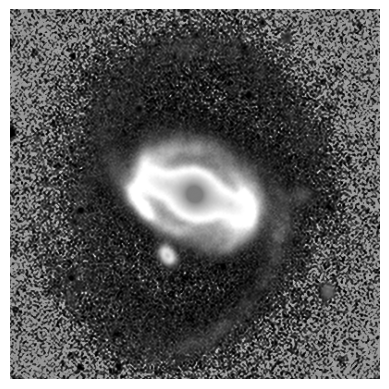

In [20]:
result = processor.preprocess(observation)

plt.imshow(result, cmap='gray')
plt.axis('off')

### Changing zoom level

The existing processor applies a zoom factor of 2, which results in 400x400 images. This can be applied by changing the zoom factor of the `center_zoom_transformer`.

For example, a zoom factor of 1.25 will result in 640x640 images.

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

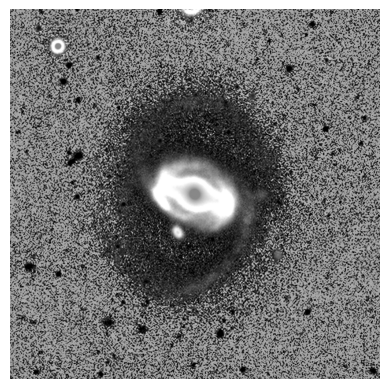

In [21]:
processor = GRDiffProcessor(
    g_transform=make_image_pipeline(
        adaptive_normalize_transformer(),
        bilateral_filter_transformer()
    ),
    r_transform=make_image_pipeline(
        log_transformer()
    ),
    result_transform=make_image_pipeline(
        center_zoom_transformer(1.25),
        adaptive_normalize_transformer(),
    )
)

plt.imshow(processor.preprocess(observation), cmap='gray')
plt.axis('off')

### Background remover

For FITS images, the `remove_background_transformer` can help clear out the background noise.

For it to work best, apply it before other transformations.

For example, the following applies it only to the R band. This helps because now we only subtract the region of interest while leaving everything else unchanged.



(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

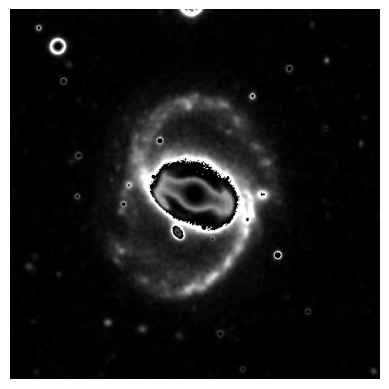

In [22]:
processor = GRDiffProcessor(
    g_transform=make_image_pipeline(
        adaptive_normalize_transformer(),
        bilateral_filter_transformer()
    ),
    r_transform=make_image_pipeline(
        remove_background_transformer(),
        log_transformer()
    ),
    result_transform=make_image_pipeline(
        center_zoom_transformer(1.25),
        adaptive_normalize_transformer(),
        power_transformer(1.75)
    )
)

plt.imshow(processor.preprocess(observation), cmap='gray')
plt.axis('off')

### GR Ratio processor

This processor divides the values of the G band by the values of the R band. It can be customized in the same way as the GRDiffProcessor.

In this case, we remove the background to the G band, then apply a squared transformer to the R band before dividing them.

The background removal of the G band ensures all the background is completely black, while the application of the squared transform to the R band ensures that regions of high intensity in the R band are amplified. Since the R band is the denominator, the resulting value is smaller, which is why the bar is darker in the result.

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

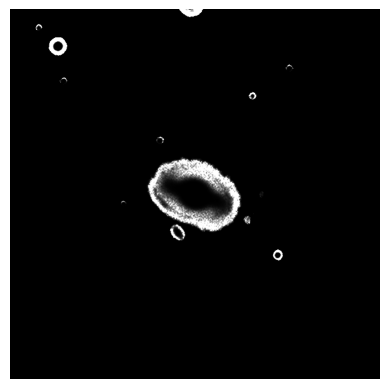

In [23]:
processor = GRRatioProcessor(
    g_transform=make_image_pipeline(
        remove_background_transformer(),
        adaptive_normalize_transformer(),
        bilateral_filter_transformer()
    ),
    r_transform=make_image_pipeline(
        squared_transformer(),
        normalize_transformer()
    ),
    result_transform=make_image_pipeline(
        center_zoom_transformer(1.25),
        adaptive_normalize_transformer(),
        power_transformer(2.5)
    )
)

plt.imshow(processor.preprocess(observation), cmap='gray')
plt.axis('off')

### RGB/JPG processor

As an additional option, the RGBProcessor will process the original JPG image. This processor will always return an RGB image. Processing is done to the image as a whole, not on a band-by-band basis.

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

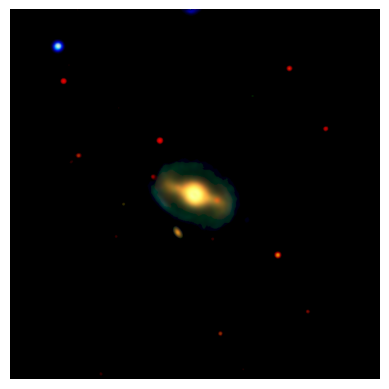

In [24]:
processor = RGBProcessor(
    transform=make_image_pipeline(
        bilateral_filter_transformer(),
        normalize_transformer(),
        power_transformer(3),
        remove_background_transformer(),
        center_zoom_transformer(1.25),
    )
)

plt.imshow(processor.preprocess(observation))
plt.axis('off')